# Wearables Lab 4 - Hedman, Koivisto & Wahlin

In [5]:
import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import signal

from ecgdetectors import Detectors

sns.set_style('darkgrid')

## Helper Functions

In [2]:
b_low = np.array([1, 0, 0, 0, 0, 0, -2, 0, 0, 0, 0, 0, 1])
a_low = np.array([1, -2, 1])
b_high = np.concatenate([[-1/32], np.zeros(15), [1], [-1], np.zeros(15), [1/32]])
a_high = np.array([1, -1])
b_der = (1/8) * np.array([1, 2, 0, -2, -1])
a_der = np.array([1])

# Low-pass filter
def low_pass_filter(data):
    return sp.signal.lfilter(b_low, a_low, data)

# High-pass filter
def high_pass_filter(data):
    return sp.signal.lfilter(b_high, a_high, data)

# derivative filter
def derivative_filter(data):
    return sp.signal.lfilter(b_der, a_der, data)

# Squaring function
def squaring(data):
    return data ** 2

# Moving window integration
def moving_window(ecg, window_size):
    return np.convolve(ecg, np.ones(window_size) / window_size, mode='same')

# Zero phase filter
def butterworth_filter(data, lowcut, highcut, sampling_f, order=5):
    nyquist = 0.5 * sampling_f
    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = sp.signal.butter(order, [low, high], btype='band')
    return sp.signal.filtfilt(b, a, data)

## Load the Data

In [ ]:
data = sp.io.loadmat('/anxietyDataR.mat')

# Extract the data
keys = list(data.keys())

# Exclude the __header__, __version__, __globals__ keys
keys = keys[3:]

for key in keys:
    print(f'{key}: {data[key].shape}')

ecgBase: (55, 30000)
ecgClip: (55, 8, 6000)
fs: (1, 1)
numClips: (1, 1)
numPat: (1, 1)
respBase: (55, 30000)
respClip: (55, 8, 6000)
sizeBase: (55, 1)
sizeClip: (55, 8)
swBase: (55, 30000)
swClip: (55, 8, 6000)


In [7]:
data['ecgClip']

array([[[-0.05566406,  0.        , -0.05859375, ..., -0.12011719,
         -0.14355469, -0.046875  ],
        [-0.09082031, -0.08203125, -0.05859375, ...,  0.24902344,
          0.7734375 , -0.65039062],
        [-0.06152344, -0.06152344, -0.02929688, ..., -0.08789062,
         -0.06738281, -0.07617188],
        ...,
        [ 0.04980469,  0.04394531,  0.12011719, ..., -0.18457031,
         -0.1171875 , -0.12597656],
        [ 0.05566406,  0.04394531, -0.02636719, ..., -0.02929688,
         -0.09375   , -0.046875  ],
        [-0.046875  , -0.03808594, -0.01171875, ..., -0.08496094,
          0.08203125,  0.02050781]],

       [[-0.08496094, -0.06152344, -0.05859375, ...,  0.0234375 ,
         -0.09082031,  0.05273438],
        [-0.02636719, -0.04394531, -0.04980469, ...,  0.1171875 ,
          0.11425781,  0.05566406],
        [-0.06445312, -0.04394531, -0.046875  , ...,  0.06738281,
          0.12890625,  0.08789062],
        ...,
        [-0.28417969, -0.2578125 , -0.21972656, ..., -

In [8]:
print(f'Number of patients: {data["numPat"]}')
print(f'Number of clips: {data["numClips"]}')
print(f'sampling rate: {data["fs"]}')

Number of patients: [[55]]
Number of clips: [[8]]
sampling rate: [[100]]


In [9]:
ecgBase = data['ecgBase']
respBase = data['respBase']
swBase = data['swBase']

sampling_f = data['fs'][0][0]

## Signal Processing

Text(0, 0.5, 'Amplitude')

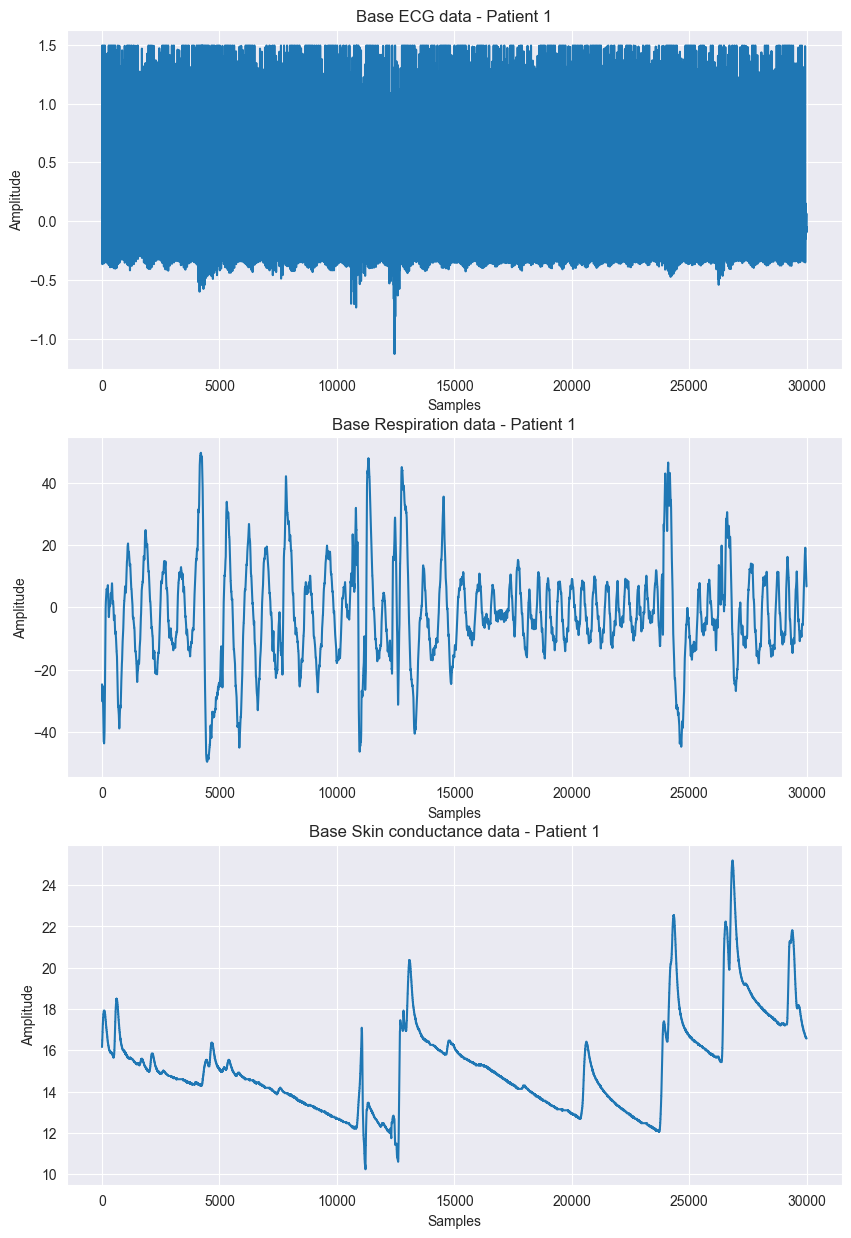

In [10]:
# Plot the ECG data for the first patient
fig, axes = plt.subplots(3, figsize=(10, 15))

axes[0].plot(ecgBase[0, :])
axes[0].set_title('Base ECG data - Patient 1')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')

axes[1].plot(respBase[0, :])
axes[1].set_title('Base Respiration data - Patient 1')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Amplitude')

axes[2].plot(swBase[0, :])
axes[2].set_title('Base Skin conductance data - Patient 1')
axes[2].set_xlabel('Samples')
axes[2].set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

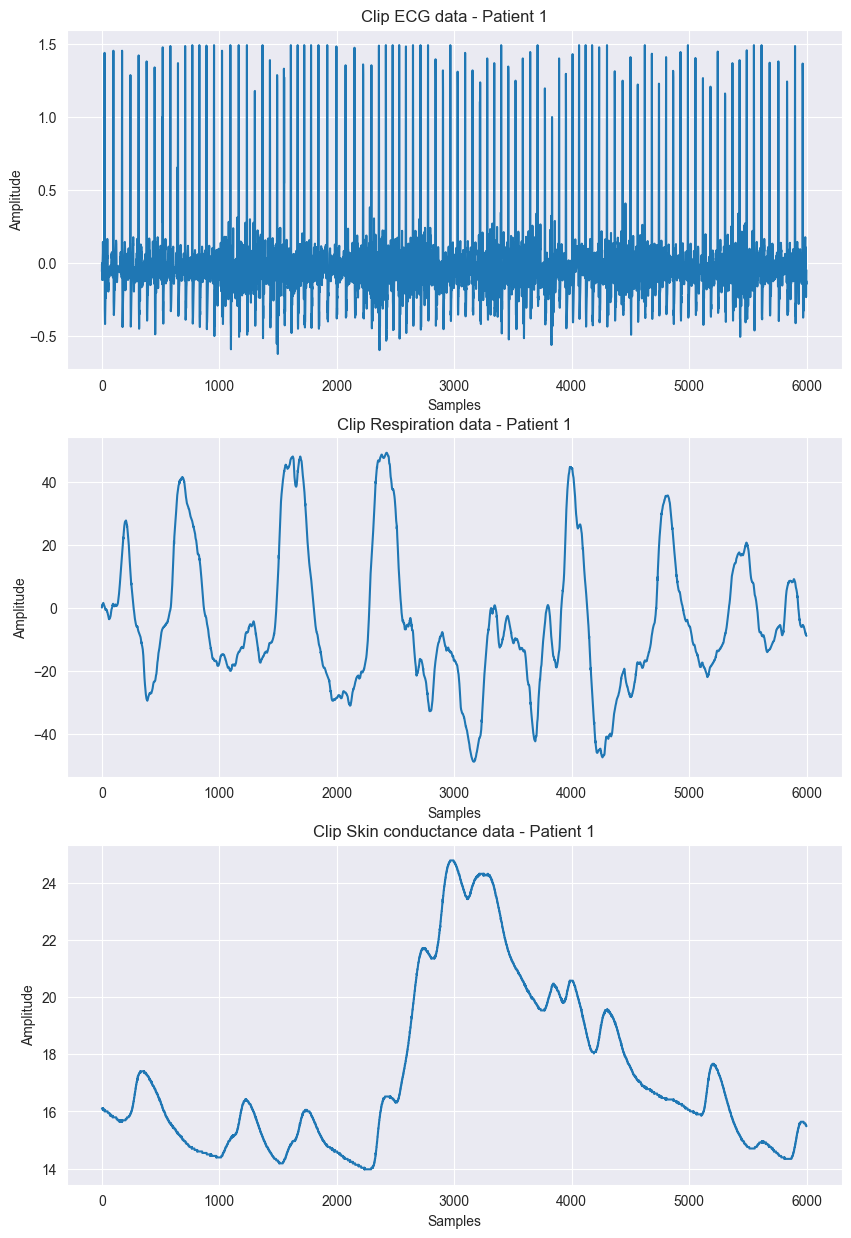

In [11]:
# Plot first clip of the first patient
ecgClip = data['ecgClip']
respClip = data['respClip']
swClip = data['swClip']

fig, axes = plt.subplots(3, figsize=(10, 15))

axes[0].plot(ecgClip[0, 0, :])
axes[0].set_title('Clip ECG data - Patient 1')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')

axes[1].plot(respClip[0, 0, :])
axes[1].set_title('Clip Respiration data - Patient 1')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Amplitude')

axes[2].plot(swClip[0, 0, :])
axes[2].set_title('Clip Skin conductance data - Patient 1')
axes[2].set_xlabel('Samples')
axes[2].set_ylabel('Amplitude')

C:\Users\pinja\AppData\Local\Temp\ipykernel_31612\2552306113.py:2: RuntimeWarning: overflow encountered in scalar multiply
  ecg_clip = ecgBase[0, :10 * sampling_f]


Text(0, 0.5, 'Amplitude')

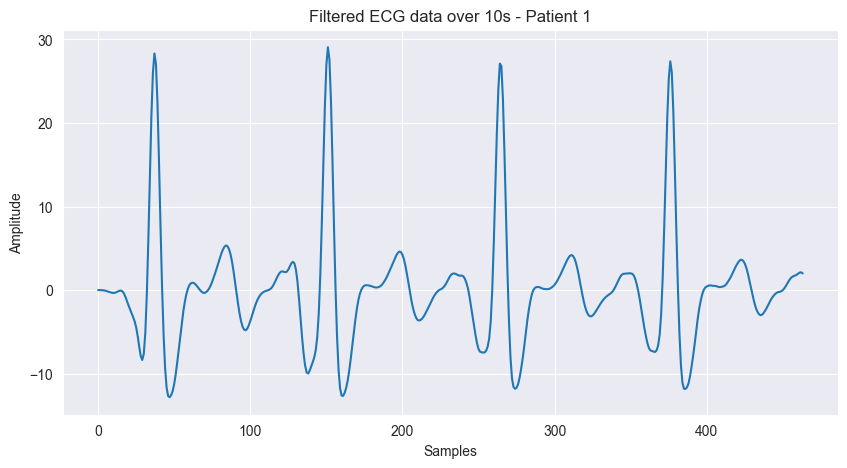

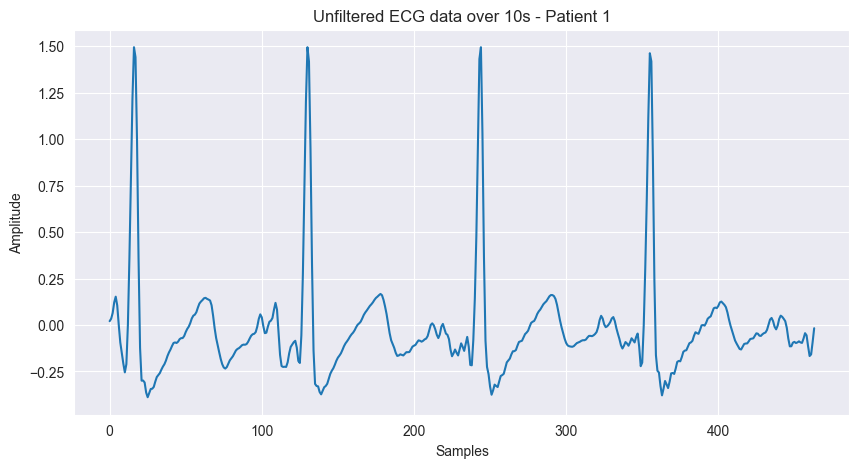

In [12]:
# 10s ECG clip
ecg_clip = ecgBase[0, :10 * sampling_f]

# Upsample from 100Hz to 200Hzs
ecg_upsampled = sp.signal.resample(ecg_clip, 2 * len(ecg_clip))

ecg_filt = high_pass_filter(low_pass_filter(ecg_upsampled))

# Plot the filtered ECG data
plt.figure(figsize=(10, 5))
plt.plot(ecg_filt)
plt.title('Filtered ECG data over 10s - Patient 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Plot unfilted ECG data
plt.figure(figsize=(10, 5))
plt.plot(ecg_upsampled)
plt.title('Unfiltered ECG data over 10s - Patient 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')


c:\Users\pinja\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\signal\_filter_design.py:480: RuntimeWarning: invalid value encountered in divide
  h = (npp_polyval(zm1, b, tensor=False) /


Text(0, 0.5, 'Magnitude')

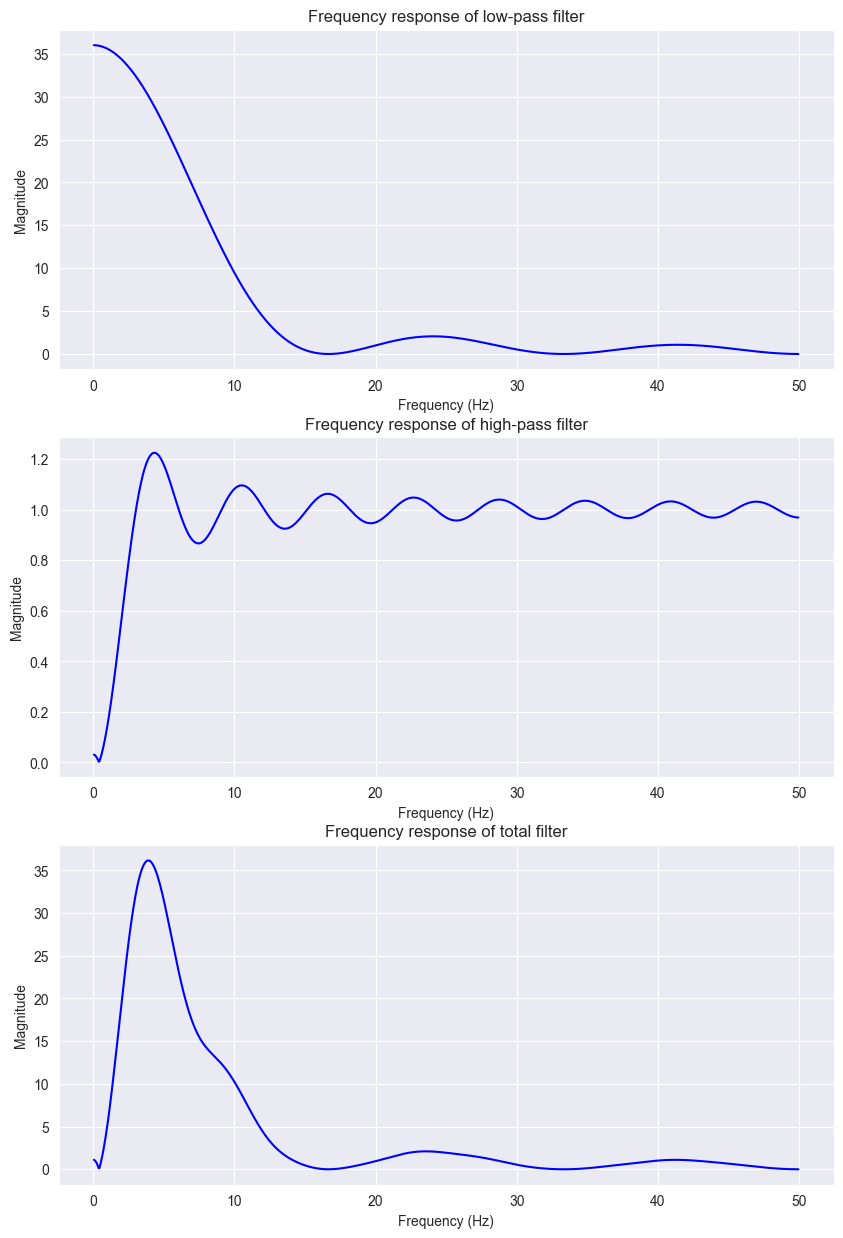

In [13]:
# Plot the frequncy response of the filters
w_low, h_low = sp.signal.freqz(b_low, a_low, worN=1024)
w_high, h_high = sp.signal.freqz(b_high, a_high, worN=1024)
w_tot, h_tot = sp.signal.freqz(np.convolve(b_low, b_high), np.convolve(a_low, a_high), worN=1024)

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

axes[0].plot((w_low / np.pi) * sampling_f/2, np.abs(h_low), 'b')
axes[0].set_title('Frequency response of low-pass filter')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Magnitude')

axes[1].plot((w_high / np.pi) * sampling_f/2, np.abs(h_high), 'b')
axes[1].set_title('Frequency response of high-pass filter')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')

axes[2].plot((w_tot / np.pi) * sampling_f/2, np.abs(h_tot), 'b')
axes[2].set_title('Frequency response of total filter')
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Magnitude')

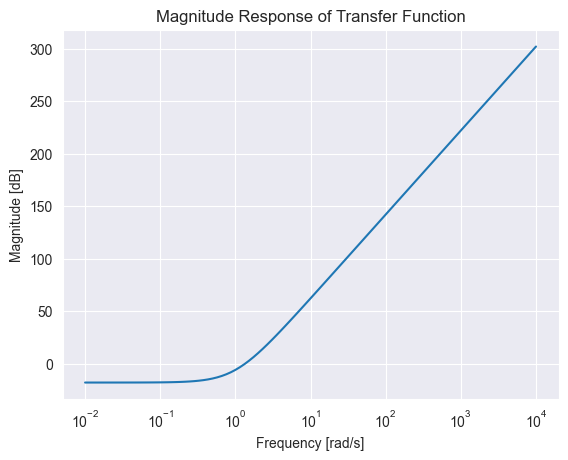

"\nw_der, h_der = sp.signal.freqz(b_der, b_der, worN=1024)\nplt.figure(figsize=(10, 5))\nplt.plot((w_der / np.pi) * sampling_f/2, np.abs(h_der), 'b')\nplt.title('Frequency response of derivative filter')\nplt.xlabel('Frequency (Hz)')\nplt.ylabel('Magnitude')\n"

In [14]:
# Plot the frequency response of the derivative filter

system = signal.TransferFunction(b_der, a_der)

w, mag, phase = signal.bode(system)

plt.figure()
plt.semilogx(w, mag)
plt.title('Magnitude Response of Transfer Function')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Magnitude [dB]')

plt.show()

"""
w_der, h_der = sp.signal.freqz(b_der, b_der, worN=1024)
plt.figure(figsize=(10, 5))
plt.plot((w_der / np.pi) * sampling_f/2, np.abs(h_der), 'b')
plt.title('Frequency response of derivative filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
"""

## Pan Tompkins - Own Implementation

Threshold: 2.7873508222001266


Text(0, 0.5, 'Amplitude')

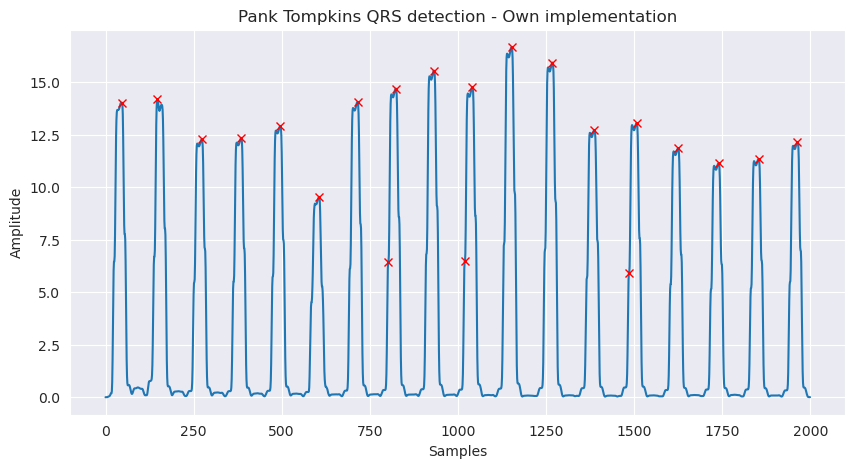

In [12]:
# Apply derivative filter
ecg_der = derivative_filter(ecg_filt)

# Squaring
ecg_sqr = squaring(ecg_der)

# Moving window integration
ecg_mwi = moving_window(ecg_sqr, 30)

# Compute the threshold for peak detection
estNoise = np.mean(ecg_mwi) / 2
estSig = np.max(ecg_mwi) / 3
threshold = estNoise + 0.25 * (estSig - estNoise)

print(f'Threshold: {threshold}')

peaks = sp.signal.find_peaks(ecg_mwi, height=threshold, distance = 0.2 * sampling_f)[0]

# Plot the ECG data with peaks
plt.figure(figsize=(10, 5))
plt.plot(ecg_mwi)
plt.plot(peaks, ecg_mwi[peaks], 'rx')
plt.title('Pank Tompkins QRS detection - Own implementation')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

## Pan Tompkins - py-ecg

Text(0, 0.5, 'Amplitude')

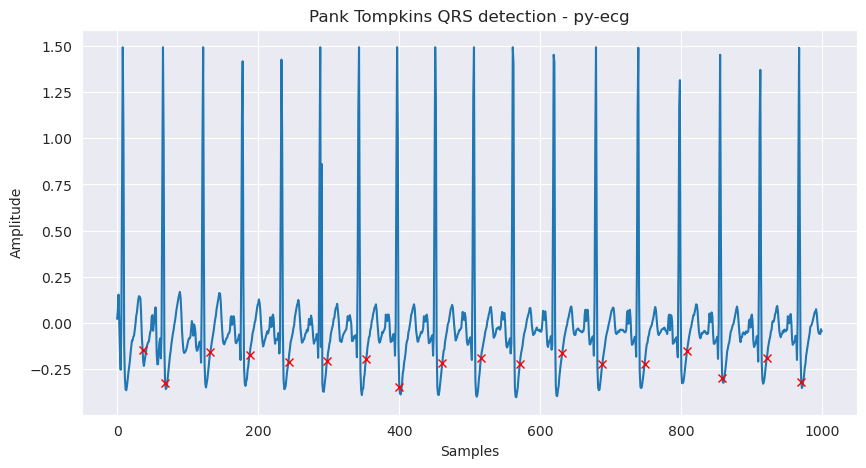

In [13]:
detectors = Detectors(sampling_f)
r_peaks = detectors.pan_tompkins_detector(ecg_clip)

# Plot the ECG data with R-peaks
plt.figure(figsize=(10, 5))
plt.plot(ecg_clip)
plt.plot(r_peaks, ecg_clip[r_peaks], 'rx')
plt.title('Pank Tompkins QRS detection - py-ecg')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

## Wavelets

Text(0, 0.5, 'Amplitude')

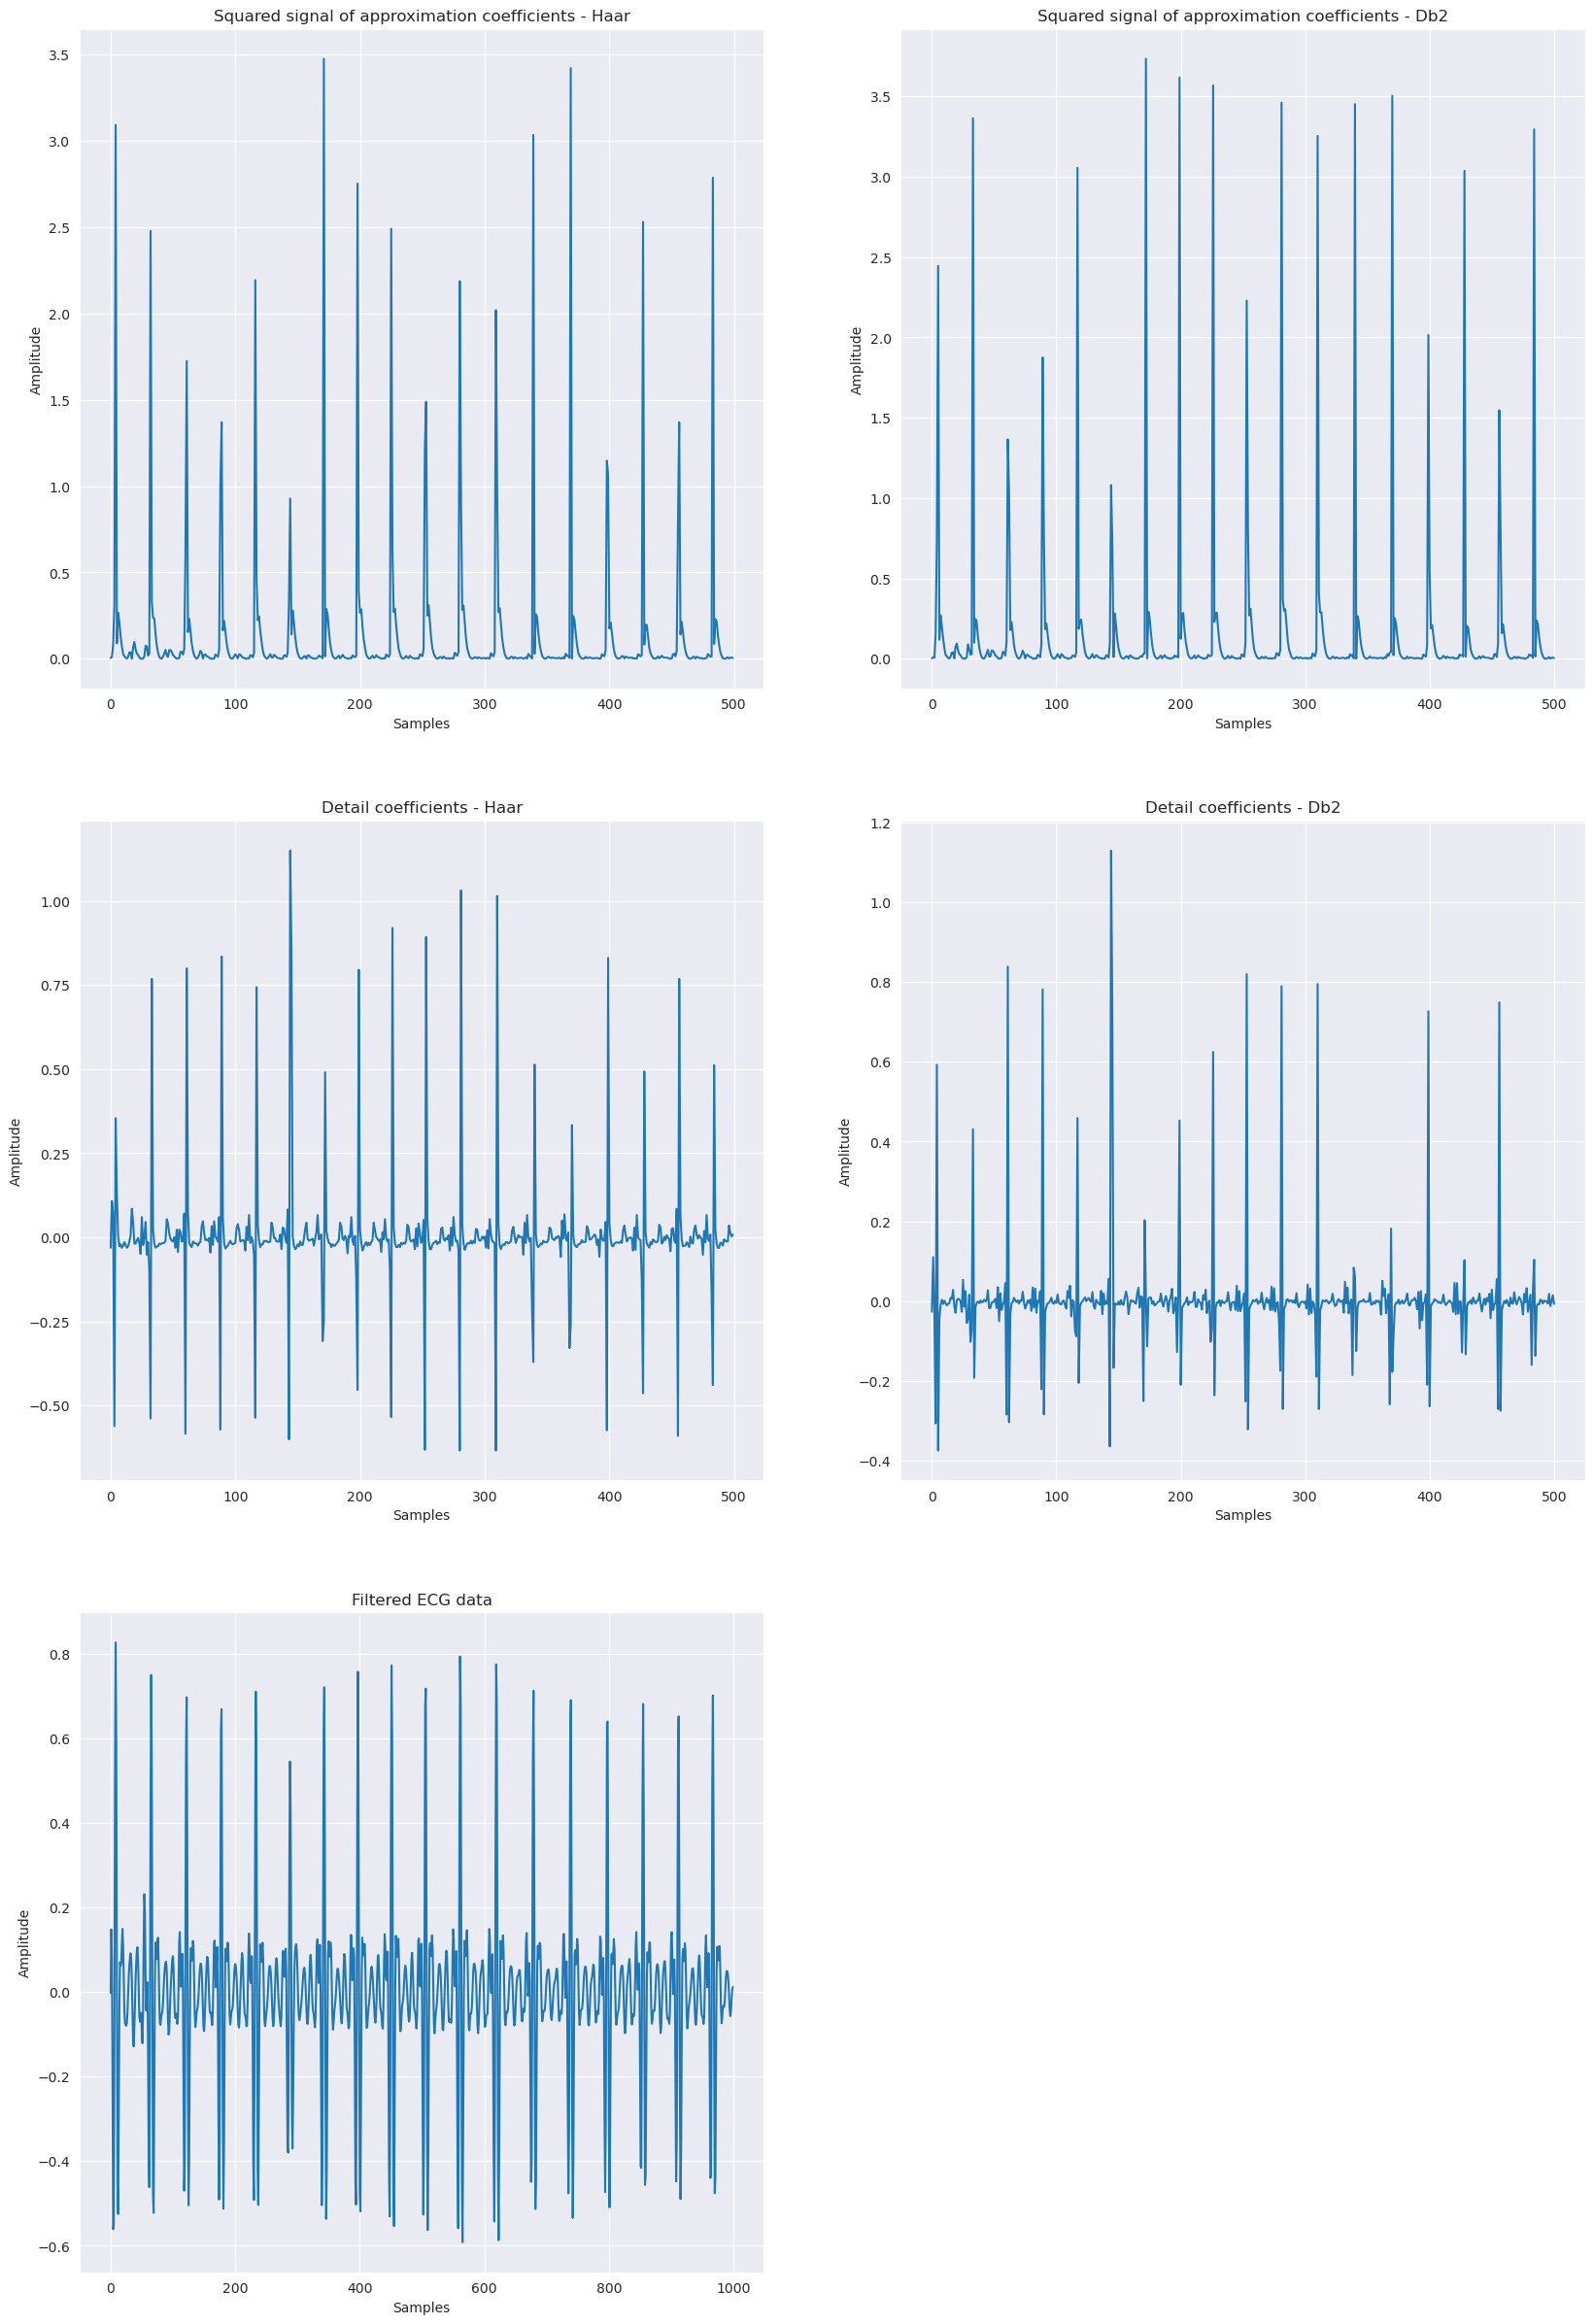

In [14]:
# Zero phase butterworth filter
cutoff_low = 8
cutoff_high = 20
ecg_filt = butterworth_filter(ecg_clip, cutoff_low, cutoff_high, sampling_f)

# Haar filtered signal
coeffs_haar = pywt.wavedec(ecg_clip, 'haar', level=1)
cA_haar, cD_haar = coeffs_haar

# Db2 filtered signal
coeffs_db2 = pywt.wavedec(ecg_clip, 'db2', level=1)
cA_db2, cD_db2 = coeffs_db2

# Squared signal of approximation coefficients
cA_haar_sqr = squaring(cA_haar)
cA_db2_sqr = squaring(cA_db2)

fig, axes = plt.subplots(3, 2, figsize=(20, 30))

# remove last plot
fig.delaxes(axes[2, 1])

axes[0, 0].plot(cA_haar_sqr)
axes[0, 0].set_title('Squared signal of approximation coefficients - Haar')
axes[0, 0].set_xlabel('Samples')
axes[0, 0].set_ylabel('Amplitude')

axes[0, 1].plot(cA_db2_sqr)
axes[0, 1].set_title('Squared signal of approximation coefficients - Db2')
axes[0, 1].set_xlabel('Samples')
axes[0, 1].set_ylabel('Amplitude')

axes[1, 0].plot(cD_haar)
axes[1, 0].set_title('Detail coefficients - Haar')
axes[1, 0].set_xlabel('Samples')
axes[1, 0].set_ylabel('Amplitude')

axes[1, 1].plot(cD_db2)
axes[1, 1].set_title('Detail coefficients - Db2')
axes[1, 1].set_xlabel('Samples')
axes[1, 1].set_ylabel('Amplitude')

axes[2, 0].plot(ecg_filt)
axes[2, 0].set_title('Filtered ECG data')
axes[2, 0].set_xlabel('Samples')
axes[2, 0].set_ylabel('Amplitude')


## Peak detection - Own implementation

Text(0, 0.5, 'Amplitude')

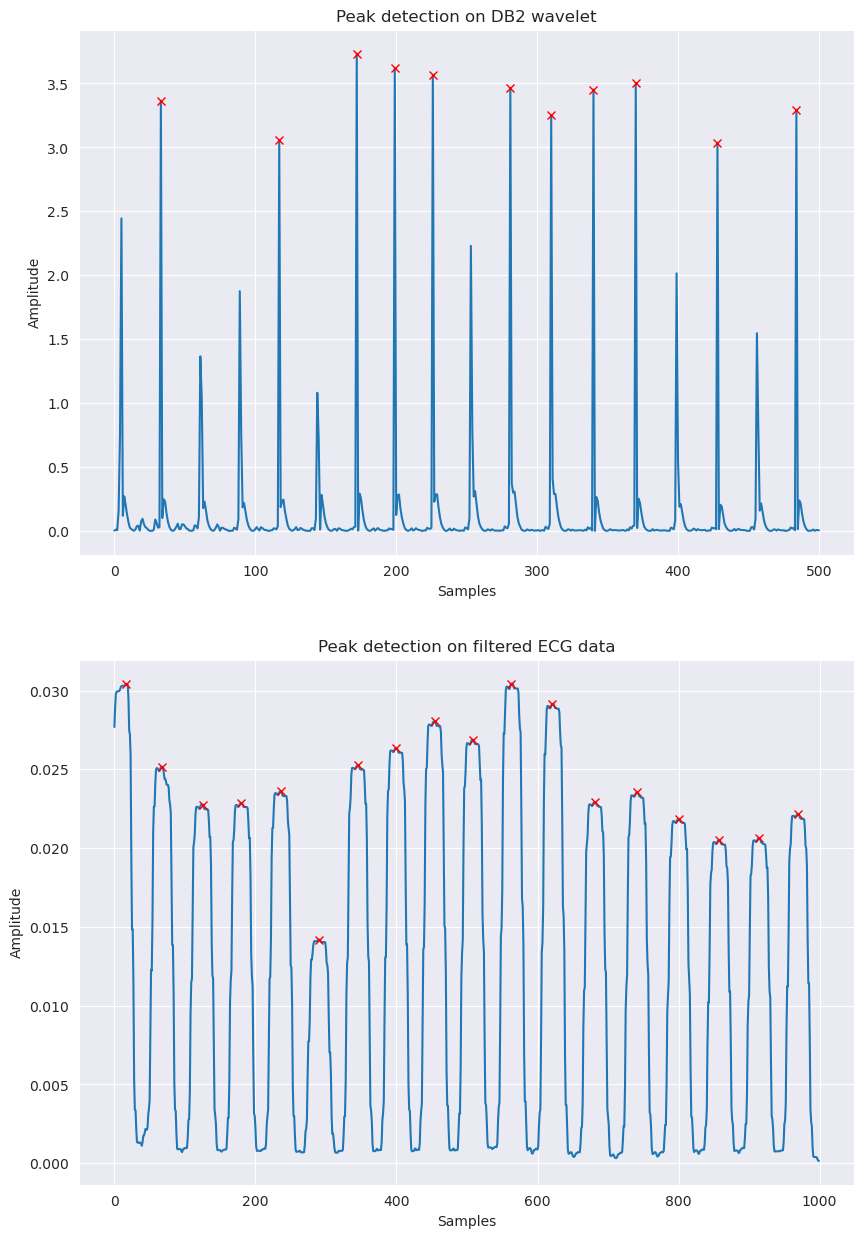

In [15]:
# Peak detection on the most suitable wavelet - Haar
peaks_db2 = sp.signal.find_peaks(cA_db2_sqr, height=threshold, distance=0.2*sampling_f)[0]

# Peak detection on the filtered ECG data
ecg_der = derivative_filter(ecg_filt)
ecg_sqr = squaring(ecg_der)
ecg_mwi = moving_window(ecg_sqr, 30)

estNoise = np.mean(ecg_mwi) / 2
estSig = np.max(ecg_mwi) / 3
threshold = estNoise + 0.25 * (estSig - estNoise)
peaks_filt = sp.signal.find_peaks(ecg_mwi, height=threshold, distance=0.2*sampling_f)[0]

# Plot the DB2 and filtered ECG data with peaks
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

axes[0].plot(cA_db2_sqr)
axes[0].plot(peaks_db2, cA_db2_sqr[peaks_db2], 'rx')
axes[0].set_title('Peak detection on DB2 wavelet')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')

axes[1].plot(ecg_mwi)
axes[1].plot(peaks_filt, ecg_mwi[peaks_filt], 'rx')
axes[1].set_title('Peak detection on filtered ECG data')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Amplitude')

In [16]:
print("Heart Rate DB2: ", 60 * len(peaks_db2) / 10)
print("Heart Rate filtered: ", 60 * len(peaks_filt) / 10)


Heart Rate DB2:  66.0
Heart Rate filtered:  108.0


## Peak detection - py-ecg

Text(0, 0.5, 'Amplitude')

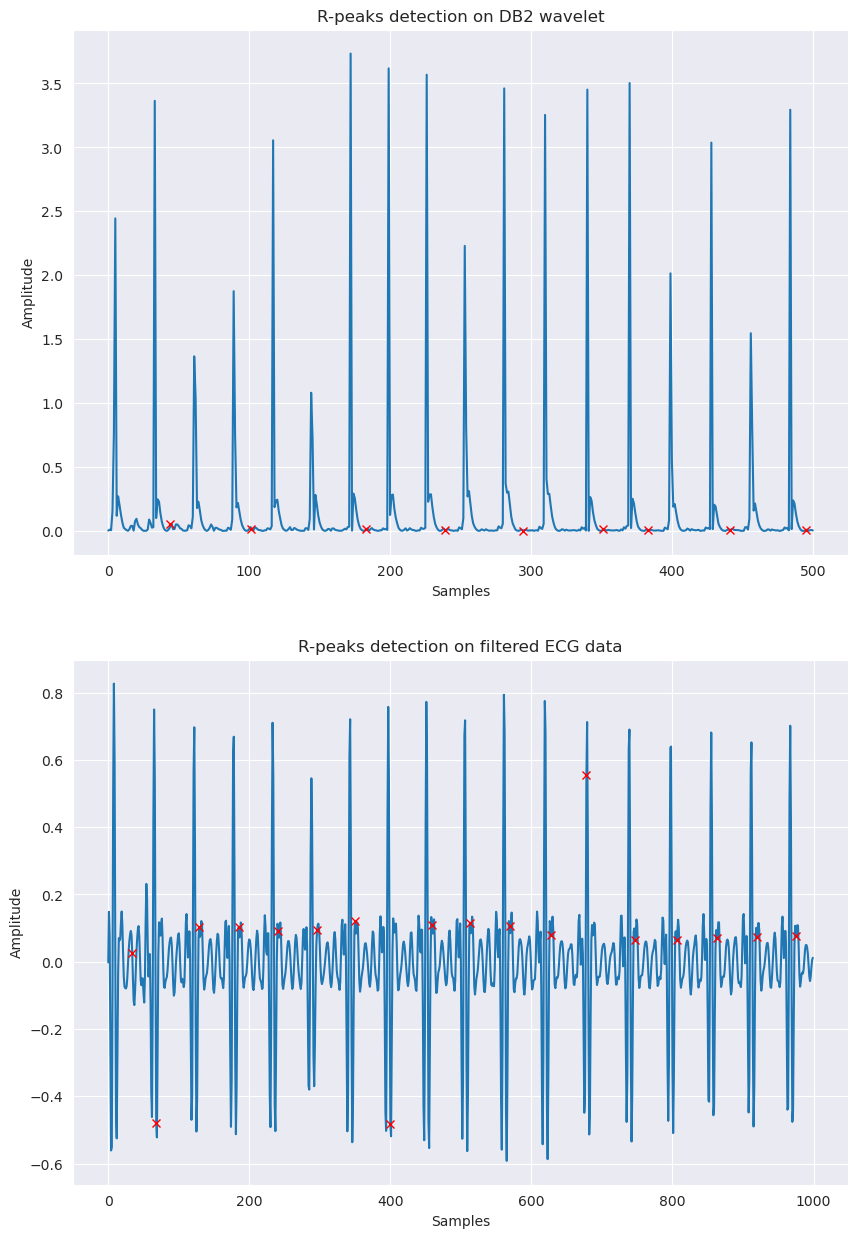

In [17]:
detectors = Detectors(sampling_f)
r_peaks_db2 = detectors.pan_tompkins_detector(cA_db2_sqr)

r_peaks_filt = detectors.pan_tompkins_detector(ecg_filt)

# plot the R-peaks
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

axes[0].plot(cA_db2_sqr)
axes[0].plot(r_peaks_db2, cA_haar_sqr[r_peaks_db2], 'rx')
axes[0].set_title('R-peaks detection on DB2 wavelet')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Amplitude')

axes[1].plot(ecg_filt)
axes[1].plot(r_peaks_filt, ecg_filt[r_peaks_filt], 'rx')
axes[1].set_title('R-peaks detection on filtered ECG data')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Amplitude')

In [18]:
print("Heart Rate DB2: ", 60 * len(r_peaks_db2) / 10)
print("Heart Rate filtered: ", 60 * len(r_peaks_filt) / 10)

Heart Rate DB2:  54.0
Heart Rate filtered:  108.0


## Feature Extraction

Extracting features. 

Baseline: 1min window & 5min recordings --> 5 windows per patient = 5x55 windows in total 
Anxiety: 1min window & 8x1min recordings --> 8 windows per patient = 8x55 windows in total

In [19]:
import neurokit2 as nk

# Array to store the features
ecgBaseFeatures = np.zeros((ecgBase.shape[0], 5))

# Extracting features
for patient in range(ecgBase.shape[0]):
    pBase = ecgBase[patient, :]
        
    window_size = 60 * sampling_f
    
    # Extract the base features
    step = 0
    heart_rates = []
    hrvs = []
    rr_intervals = []
    
    while(step < pBase.shape[0]):
        window = pBase[step:step+window_size]
        
        #check for NaN values
        if np.isnan(window).any():
            print("NaN values found")
            print("Number of NaN values: ", np.isnan(window).sum())
            step += window_size
            continue
                
        # Filter the raw ECG data
        ecg_filt = butterworth_filter(window, 8, 20, sampling_f)
        
        # Peak detection with neurokit
        r_peaks = nk.ecg_findpeaks(ecg_filt, sampling_rate=sampling_f)
        
        # Check if there are less than 2 R-peaks
        if len(r_peaks['ECG_R_Peaks']) < 2:
            step += window_size
            continue 
                
        # Heart rate
        heart_rate = np.mean(nk.ecg_rate(r_peaks, sampling_rate=sampling_f))
        heart_rates.append(heart_rate)
        
        # Heart rate variability
        hrv = nk.hrv_time(r_peaks, sampling_rate=sampling_f)
        hrvs.append(float(hrv['HRV_MeanNN']))
        
        # RR intervals (ms)
        rr_interval = np.diff(r_peaks['ECG_R_Peaks'])
        rr_interval = np.mean(rr_interval / sampling_f)
                
        rr_intervals.append(rr_interval)
                           
        step += window_size
          
    mean_hr = np.mean(heart_rates)
    std_hr = np.std(heart_rates)
    mean_hrv = np.mean(hrvs)
    mean_rri = np.mean(rr_intervals)
    std_rri = np.std(rr_intervals)
    print("Patient: ", patient + 1)
    print("mean heart rate: ", mean_hr)
    print("std heart rate: ", std_hr)
    print("HRV: ", mean_hrv)
    print("Mean RR interval: ", mean_rri)
    print("Std RR interval: ", std_rri)
    print()
    
    # Store the features
    ecgBaseFeatures[patient, 0] = mean_hr
    ecgBaseFeatures[patient, 1] = std_hr
    ecgBaseFeatures[patient, 2] = mean_hrv
    ecgBaseFeatures[patient, 3] = mean_rri
    ecgBaseFeatures[patient, 4] = std_rri

Patient:  1
mean heart rate:  92.70719534280303
std heart rate:  1.8818707955256153
HRV:  655.116671807868
Mean RR interval:  0.6551166718078679
Std RR interval:  0.014998306011743878

Patient:  2
mean heart rate:  72.7801823238737
std heart rate:  0.8584773589901471
HRV:  827.5613021563726
Mean RR interval:  0.8275613021563727
Std RR interval:  0.009477720694308642

Patient:  3
mean heart rate:  74.50648276111863
std heart rate:  2.6527718870243575
HRV:  814.4879295771746
Mean RR interval:  0.8144879295771744
Std RR interval:  0.026923447157376844

Patient:  4
mean heart rate:  77.01127980111703
std heart rate:  1.2597230271598607
HRV:  782.3178308178308
Mean RR interval:  0.7823178308178309
Std RR interval:  0.012737565498431424

Patient:  5
mean heart rate:  101.16616463751295
std heart rate:  2.5668559178509343
HRV:  594.5718253968254
Mean RR interval:  0.5945718253968254
Std RR interval:  0.015068217903625196

Patient:  6
mean heart rate:  83.55831542415994
std heart rate:  1.3840

In [20]:
ecgBaseFeatures.shape

(55, 5)

In [21]:
ecgClip = data['ecgClip']
ecgClip.shape

(55, 8, 6000)

In [22]:
# ecgClip.shape = (55, 8, 6000)

# Extract the features for the ECG clips
ecgClipFeatures = np.zeros((ecgClip.shape[0], 5))

for patient in range(ecgClip.shape[0]):
    print(f'Patient: {patient + 1}')
        
    heart_rates = []
    hrvs = []
    rr_intervals = []
        
    for clip in range(ecgClip.shape[1]):
        pClip = ecgClip[patient, clip, :]
                
        # Check for NaN values
        if np.isnan(pClip).any():
            print("NaN values found")
            print("Number of NaN values: ", np.isnan(pClip).sum())
            continue
            
        # Filter the raw ECG data
        ecg_filt = butterworth_filter(pClip, 8, 20, sampling_f)
        
        # Peak detection with neurokit
        r_peaks = nk.ecg_findpeaks(ecg_filt, sampling_rate=sampling_f)
        
        # Check if there are at least 2 R-peaks
        if len(r_peaks['ECG_R_Peaks']) < 2:
            continue
            
        # Heart rate
        heart_rate = np.mean(nk.ecg_rate(r_peaks, sampling_rate=sampling_f))
        heart_rates.append(heart_rate)
        
        # Heart rate variability
        hrv = nk.hrv_time(r_peaks, sampling_rate=sampling_f)
        hrvs.append(float(hrv['HRV_MeanNN']))
        
        # RR intervals (ms)
        rr_interval = np.diff(r_peaks['ECG_R_Peaks'])
        rr_interval = np.mean(rr_interval / sampling_f)
        
        rr_intervals.append(rr_interval)
                        
    mean_hr = np.mean(heart_rates)
    std_hr = np.std(heart_rates)
    mean_hrv = np.mean(hrvs)
    mean_rri = np.mean(rr_intervals)
    std_rri = np.std(rr_intervals)
    print("mean heart rate: ", mean_hr)
    print("std heart rate: ", std_hr)
    print("HRV: ", mean_hrv)
    print("Mean RR interval: ", mean_rri)
    print("Std RR interval: ", std_rri)
    print()
    
    # Store the features
    ecgClipFeatures[patient, 0] = mean_hr
    ecgClipFeatures[patient, 1] = std_hr
    ecgClipFeatures[patient, 2] = mean_hrv
    ecgClipFeatures[patient, 3] = mean_rri
    ecgClipFeatures[patient, 4] = std_rri    

Patient: 1
mean heart rate:  89.81038030028246
std heart rate:  3.246090891191261
HRV:  674.8043075804371
Mean RR interval:  0.6748043075804371
Std RR interval:  0.02505314596943579

Patient: 2
mean heart rate:  72.37109034568843
std heart rate:  2.070464393729142
HRV:  832.1129201680673
Mean RR interval:  0.8321129201680673
Std RR interval:  0.02287052526161493

Patient: 3
mean heart rate:  79.5261608994419
std heart rate:  1.550139724200623
HRV:  761.6505767661164
Mean RR interval:  0.7616505767661164
Std RR interval:  0.015133348711031986

Patient: 4
mean heart rate:  70.9803813329415
std heart rate:  2.8066551163314233
HRV:  850.4403343852641
Mean RR interval:  0.8504403343852641
Std RR interval:  0.03333279619001505

Patient: 5
mean heart rate:  93.93054412750739
std heart rate:  2.8065648969895496
HRV:  642.3231847280998
Mean RR interval:  0.6423231847280998
Std RR interval:  0.018609211986974693

Patient: 6
mean heart rate:  89.57066981437455
std heart rate:  2.677605362914527
H

In [23]:
ecgClipFeatures.shape

(55, 5)

In [24]:
# respiration data
respBase = data['respBase']
respClip = data['respClip']

respBase.shape, respClip.shape

((55, 30000), (55, 8, 6000))

In [26]:
# Electrodermal activity
swBase = data['swBase']
swClip = data['swClip']

npMinBase = np.min(swBase, axis=1)
npMaxBase = np.max(swBase, axis=1)
npMinClip = np.min(swClip, axis=1)
npMaxClip = np.max(swClip, axis=1)

swBase.shape, swClip.shape

((55, 30000), (55, 8, 6000))

In [27]:
swBaseFeatures = np.zeros((swBase.shape[0], 5))

for patient in range(swBase.shape[0]):
    print(f'Patient: {patient + 1}')
    
    pSwBase = swBase[patient, :]
        
    window_size = 60 * sampling_f
    
    step = 0
    means = []
    stds = []
    mean_first_differences = []
    mean_second_differences = []
    n_peaks = []
    
    while(step < pSwBase.shape[0]):
        window = pSwBase[step:step+window_size]
        
        #check for NaN values
        if np.isnan(window).any():
            step += window_size
            continue
        
        eda_normalized = (window - npMinBase[patient]) / (npMaxBase[patient] - npMinBase[patient])
        
        mean = np.mean(eda_normalized)
        means.append(mean)
        
        std = np.std(eda_normalized)
        stds.append(std)
        
        # First difference
        first_difference = np.diff(eda_normalized)
        mean_first_diff = np.mean(first_difference)
        mean_first_differences.append(mean_first_diff)
        
        # Second difference
        second_difference = np.diff(first_difference)
        mean_second_diff = np.mean(second_difference)
        mean_second_differences.append(mean_second_diff)
                
        # average number of peaks
        peaks = sp.signal.find_peaks(eda_normalized)[0]
        n_peaks.append(len(peaks))
        
        step += window_size
        
    pmean = np.mean(means)
    pstd = np.mean(stds)
    pmean_df = np.mean(mean_first_differences)
    pmean_sf = np.mean(mean_second_differences)
    pmean_peaks = np.mean(n_peaks)
    
    print("Mean: ", pmean)
    print("Std: ", pstd)
    print("Mean first differences: ", pmean_df)
    print("Mean second differences: ", pmean_sf)
    print("Mean number of peaks: ", pmean_peaks)
    print()
    
    swBaseFeatures[patient, 0] = pmean
    swBaseFeatures[patient, 1] = pstd
    swBaseFeatures[patient, 2] = pmean_df
    swBaseFeatures[patient, 3] = pmean_sf
    swBaseFeatures[patient, 4] = pmean_peaks

Patient: 1
Mean:  0.3305400462962939
Std:  0.08678062872263334
Mean first differences:  9.260802726380379e-07
Mean second differences:  -2.315586677041061e-07
Mean number of peaks:  216.0

Patient: 2
Mean:  0.4364829479409476
Std:  0.06990716428259358
Mean first differences:  -8.976930976751399e-06
Mean second differences:  -3.288407115324717e-08
Mean number of peaks:  128.6

Patient: 3
Mean:  0.4074990253411318
Std:  0.06029069093967469
Mean first differences:  -3.177917567157896e-05
Mean second differences:  -9.749838640154117e-08
Mean number of peaks:  316.0

Patient: 4
Mean:  0.33167081081081135
Std:  0.06116182938862885
Mean first differences:  -3.3519100030185214e-05
Mean second differences:  -1.8024026026694452e-07
Mean number of peaks:  383.2

Patient: 5
Mean:  0.5723800019208147
Std:  0.0979414726318103
Mean first differences:  1.6498944210454923e-05
Mean second differences:  -3.3025006270549723e-07
Mean number of peaks:  171.0

Patient: 6
Mean:  0.2549351562500002
Std:  0.058

In [28]:
swClipFeatures = np.zeros((swClip.shape[0], 5))

for patient in range(swClip.shape[0]):
    print(f'Patient: {patient + 1}')
    
    pSwClip = swClip[patient, :]
    
    means = []
    stds = []
    mean_first_differences = []
    mean_second_differences = []
    n_peaks = []
    
    for clip in range(swClip.shape[1]):
        pClip = pSwClip[clip, :]
        
        # Check for NaN values
        if np.isnan(pClip).any():
            continue
            
        eda_normalized = (pClip - npMinClip[patient]) / (npMaxClip[patient] - npMinClip[patient])
        
        mean = np.mean(eda_normalized)
        means.append(mean)
        
        std = np.std(eda_normalized)
        stds.append(std)
        
        # First difference
        first_difference = np.diff(eda_normalized)
        mean_first_diff = np.mean(first_difference)
        mean_first_differences.append(mean_first_diff)
        
        # Second difference
        second_difference = np.diff(first_difference)
        mean_second_diff = np.mean(second_difference)
        mean_second_differences.append(mean_second_diff)
        
        # average number of peaks
        peaks = sp.signal.find_peaks(eda_normalized)[0]
        n_peaks.append(len(peaks))
        
    pmean = np.mean(means)
    pstd = np.mean(stds)
    pmean_df = np.mean(mean_first_differences)
    pmean_sf = np.mean(mean_second_differences)
    pmean_peaks = np.mean(n_peaks)
    
    print("Mean: ", pmean)
    print("Std: ", pstd)
    print("Mean first differences: ", pmean_df)
    print("Mean second differences: ", pmean_sf)
    print("Mean number of peaks: ", pmean_peaks)
    print()
    
    swClipFeatures[patient, 0] = pmean
    swClipFeatures[patient, 1] = pstd
    swClipFeatures[patient, 2] = pmean_df
    swClipFeatures[patient, 3] = pmean_sf
    swClipFeatures[patient, 4] = pmean_peaks    

Patient: 1
Mean:  0.4812334816828574
Std:  0.18142194923856886
Mean first differences:  -4.885107410295832e-05
Mean second differences:  -1.1751007774547433e-06
Mean number of peaks:  476.5

Patient: 2
Mean:  0.538294748524922
Std:  0.08843464263387223
Mean first differences:  -1.2749793963362838e-07
Mean second differences:  -1.8859981984947787e-07
Mean number of peaks:  455.25

Patient: 3
Mean:  0.545078509521997
Std:  0.14708145802334197
Mean first differences:  1.7679714295816688e-06
Mean second differences:  -1.0104378227080646e-07
Mean number of peaks:  974.25

Patient: 4
Mean:  0.5189199454609059
Std:  0.09212614444737213
Mean first differences:  -4.133900662275889e-06
Mean second differences:  1.3234889800848443e-22
Mean number of peaks:  762.0

Patient: 5
Mean:  0.37747957776805247
Std:  0.05499681287898492
Mean first differences:  -5.4548624823495156e-06
Mean second differences:  -3.3932714332664674e-07
Mean number of peaks:  524.25

Patient: 6
Mean:  0.541315882294523
Std:  

## PCA and Model Training

In [29]:
# Combine the features
baseFeatures = np.concatenate([ecgBaseFeatures, swBaseFeatures], axis=1)
clipFeatures = np.concatenate([ecgClipFeatures, swClipFeatures], axis=1)

features = np.concatenate([baseFeatures, clipFeatures], axis=0) # (110, 10)

# Class labels for the patients. 0: healthy, 1: anxiety. shape (
labels = np.zeros(110)
labels[55:] = 1

# number of nan values features
nan_values = np.isnan(features).sum()
nan_values

0

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA that explains 95% of the variance
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape

((88, 7), (22, 7))

In [34]:
# Models to predict anxiety
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import balanced_accuracy_score

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_pca, y_train)

y_pred = log_reg.predict(X_test_pca)

print(f'Accuracy: {balanced_accuracy_score(y_test, y_pred):.2f}')

Accuracy: 0.82


In [35]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_pca, y_train)

y_pred = rf.predict(X_test_pca)

print(f'Accuracy: {balanced_accuracy_score(y_test, y_pred):.2f}')

Accuracy: 0.68


In [36]:
# SVC
svc = SVC()
svc.fit(X_train_pca, y_train)

y_pred = svc.predict(X_test_pca)

print(f'Accuracy: {balanced_accuracy_score(y_test, y_pred):.2f}')

Accuracy: 0.72
